# Taller Regresión y clasificación - Parte 1
## Modelo de red neuronal para diagnóstico de cáncer
### Autor: Samuel Mesa
#### Fecha: 20 de abril de 2021

### Objetivo: Construya una red neuronal de clasificación binaria para predecir el cáncer de seno.  Los datos los puede encontrar en el enlace de Kaggle.

Importar las librerias para la lectura de datos, gráficas y para definir el modelo de los datos

### Meta-información sobre los datos
* ID number
* Diagnosis (M = maligno, B = benigno)

Se calculan diez características de valor real para cada núcleo celular:

* radius (media de las distancias desde el centro a los puntos del perímetro)
* texture (desviación estándar de los valores de la escala de grises)
* perimeter
* area
* smoothness (variación local en las longitudes de los radios)
* compactness (perímetro ^ 2 / área - 1.0)
* concavity (severidad de las porciones cóncavas del contorno)
* concave points (número de porciones cóncavas del contorno)
* symetry
* fractal dimension ("aproximación de la línea de costa"

La media, el error estándar y el "peor" o el mayor (la media de los tres valores más grandes) de estas características se calcularon para cada imagen, lo que resultó en 30 características. Por ejemplo, el campo 3 es Radio medio, el campo 13 es Radio SE, el campo 23 es Peor radio.

Todos los valores de las características se recodifican con cuatro dígitos significativos.

datos faltantes: ninguno

Distribución de clases: 357 benignos, 212 malignos

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.estimator import LinearClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.utils import plot_model

 Cargar los datos desde el CSV y realiza una limpieza de borrar una columna adicional. Los datos corresponden

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/DiplomadoAI-DL-UNAL2021/samuelmesa/main/taller03_regresion_clasificacion/BreastCancerWisconsin.csv', index_col=0)
del df['Unnamed: 32']
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


 ## Preparar los datos
 Se realiza la preperación de los datos en la que se convierten los valores categóricos de diagnostico de *M* maligno a 1 y *B* benigno a 0. Separa el conjunto de datos en variables explicativas *df_X* y variables independiente *df_Y*

In [3]:
df_X = df.iloc[:,1:]
df_Y = df.apply(lambda x: 1 if x['diagnosis'] == 'M' else 0, axis=1)

## Descripción de los datos

Lo que muestra a continuación con la correlacción de los datos es que las medidas de radio, area y perímetro muestra una alta correlacción entre las variables (radio, area, perímetro), así como la medidas de compacidad y concavidad.

In [4]:
df_describe = df.describe().transpose()
print(df_describe)
correlation_data = df_X.corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)  

                         count        mean         std         min  \
radius_mean              569.0   14.127292    3.524049    6.981000   
texture_mean             569.0   19.289649    4.301036    9.710000   
perimeter_mean           569.0   91.969033   24.298981   43.790000   
area_mean                569.0  654.889104  351.914129  143.500000   
smoothness_mean          569.0    0.096360    0.014064    0.052630   
compactness_mean         569.0    0.104341    0.052813    0.019380   
concavity_mean           569.0    0.088799    0.079720    0.000000   
concave points_mean      569.0    0.048919    0.038803    0.000000   
symmetry_mean            569.0    0.181162    0.027414    0.106000   
fractal_dimension_mean   569.0    0.062798    0.007060    0.049960   
radius_se                569.0    0.405172    0.277313    0.111500   
texture_se               569.0    1.216853    0.551648    0.360200   
perimeter_se             569.0    2.866059    2.021855    0.757000   
area_se             

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


![](./img/correlaccion.png)

## Realizar el entrenamiento

A partir de los datos, se toman el 20% para validación (total 114) y el restante para entrenamiento (total 455).

In [5]:
training_features , test_features ,training_labels, test_labels = train_test_split(df_X , df_Y , test_size=0.2)
print('No. of rows in Training Features: ', training_features.shape[0])
print('No. of rows in Test Features: ', test_features.shape[0])
print('No. of columns in Training y tests Features: ', training_features.shape[1])

No. of rows in Training Features:  455
No. of rows in Test Features:  114
No. of columns in Training y tests Features:  30


### Funciones para la normalización de los datos y para definir la función generadora que entregará los datos al modelo

In [6]:
def norm(x):
  stats = x.describe()
  stats = stats.transpose()
  return (x - stats['mean']) / stats['std']

normed_train_features = norm(training_features)
normed_test_features = norm(test_features)

def get_input_fn(data_training, data_labels): 
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_training), data_labels))\
        .shuffle(True).batch(32).repeat(1)
    return dataset

## Primer modelo de clasificación lineal
### Definición del modelo y entrenamiento

In [12]:
train_fn_feeds = lambda: get_input_fn(normed_train_features,training_labels)

feature_columns_numeric = [tf.feature_column.numeric_column(m) for m in training_features.columns]
logistic_model = LinearClassifier(feature_columns=feature_columns_numeric)

logistic_model.train(train_fn_feeds)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl_idpqk2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten

## Prediciones del modelo 1 de clasificación lineal

In [13]:
testing_fn_feeds = lambda: get_input_fn(normed_train_features, training_labels)
test_fn_feeds = lambda: get_input_fn(normed_test_features, test_labels)

train_predictions = logistic_model.predict(testing_fn_feeds)
test_predictions = logistic_model.predict(test_fn_feeds)
train_predictions_series = pd.Series([p['classes'][0].decode("utf-8")   for p in train_predictions])
test_predictions_series = pd.Series([p['classes'][0].decode("utf-8")   for p in test_predictions])

train_predictions_df = pd.DataFrame(train_predictions_series, columns=['predictions'])
test_predictions_df = pd.DataFrame(test_predictions_series, columns=['predictions'])
training_labels.reset_index(drop=True, inplace=True)
train_predictions_df.reset_index(drop=True, inplace=True)

test_labels.reset_index(drop=True, inplace=True)
test_predictions_df.reset_index(drop=True, inplace=True)
train_labels_with_predictions_df = pd.concat([training_labels, train_predictions_df], axis=1)
test_labels_with_predictions_df = pd.concat([test_labels, test_predictions_df], axis=1)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpl_idpqk2/model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpl_idpqk2/model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### Validación del modelo 1

A partir de los datos de validación y los datos de predicción y entrenamiento 

In [14]:
def calculate_binary_class_scores(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred.astype('int64'))
  precision = precision_score(y_true, y_pred.astype('int64'))
  recall = recall_score(y_true, y_pred.astype('int64'))
  return accuracy, precision, recall

In [15]:
train_accuracy_score, train_precision_score, train_recall_score = calculate_binary_class_scores(training_labels, train_predictions_series)
test_accuracy_score, test_precision_score, test_recall_score = calculate_binary_class_scores(test_labels, test_predictions_series)

print('Training Data Accuracy (%) = ', round(train_accuracy_score*100,2))
print('Training Data Precision (%) = ', round(train_precision_score*100,2))
print('Training Data Recall (%) = ', round(train_recall_score*100,2))
print('-'*50)
print('Test Data Accuracy (%) = ', round(test_accuracy_score*100,2))
print('Test Data Precision (%) = ', round(test_precision_score*100,2))
print('Test Data Recall (%) = ', round(test_recall_score*100,2))


Training Data Accuracy (%) =  96.92
Training Data Precision (%) =  97.08
Training Data Recall (%) =  94.86
--------------------------------------------------
Test Data Accuracy (%) =  92.98
Test Data Precision (%) =  87.18
Test Data Recall (%) =  91.89


Los resultados entregados de presición, exactitud y memoria. 

Our accuracy is 92.98245614035088%


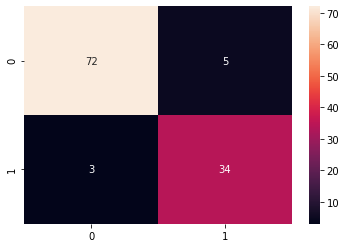

In [16]:
cm = confusion_matrix(test_labels, test_predictions_series.astype(int))
print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1])/test_labels.shape[0])*100))
sns.heatmap(cm, annot=True)
plt.savefig("img/heatmap1.png")

 ### Modelo logístico

Segunda parte de la solución usando una red neuronal de modelo logístico con un modelo Sequential modo 2

In [17]:
model_seq2 = keras.models.Sequential()
## Adiciona capas una por una
model_seq2.add(keras.layers.Dense(units=16, activation='relu', input_shape=(30,)))
# Adding dropout to prevent overfitting (regularización)
model_seq2.add(keras.layers.Dropout(0.1)) # 10% out in each epoc
model_seq2.add(keras.layers.Dense(units=16, activation='relu'))
# Adding dropout to prevent overfitting (regularización)
model_seq2.add(keras.layers.Dropout(0.1))
model_seq2.add(keras.layers.Dense(units=1, activation='sigmoid'))
model_seq2.save('hd5/modelo.h5')

 ### Compila el modelo

In [18]:
model_seq2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_seq2.summary()
#plot_model(model_seq2, to_file='./img/cancer_seno.png', show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


![](./img/modelo.png)

 ### Entrenamiento

In [19]:
history = model_seq2.fit(normed_train_features, training_labels, batch_size=32, epochs=150,validation_split = 0.2)


ss: 0.2116 - accuracy: 0.9298 - val_loss: 0.1767 - val_accuracy: 0.9560
Epoch 12/150
12/12 [==============================] - 1s 57ms/step - loss: 0.1992 - accuracy: 0.9283 - val_loss: 0.1568 - val_accuracy: 0.9780
Epoch 13/150
12/12 [==============================] - 1s 50ms/step - loss: 0.1530 - accuracy: 0.9570 - val_loss: 0.1409 - val_accuracy: 0.9780
Epoch 14/150
12/12 [==============================] - 1s 46ms/step - loss: 0.1777 - accuracy: 0.9386 - val_loss: 0.1303 - val_accuracy: 0.9780
Epoch 15/150
12/12 [==============================] - 1s 57ms/step - loss: 0.1365 - accuracy: 0.9523 - val_loss: 0.1193 - val_accuracy: 0.9780
Epoch 16/150
12/12 [==============================] - 1s 48ms/step - loss: 0.1347 - accuracy: 0.9470 - val_loss: 0.1094 - val_accuracy: 0.9780
Epoch 17/150
12/12 [==============================] - 1s 55ms/step - loss: 0.1268 - accuracy: 0.9571 - val_loss: 0.1012 - val_accuracy: 0.9780
Epoch 18/150
12/12 [==============================] - 1s 50ms/step - l

### Prediciones 

In [20]:
# Predicting the Test set results
y_pred = model_seq2.predict(normed_test_features)
#y_pred = (y_pred > 0.5)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <=0.5] = 0


 ### Matriz de confusión

In [21]:
test_accuracy_score2, test_precision_score2, test_recall_score2 = calculate_binary_class_scores(test_labels, y_pred)

print('Test Data Accuracy (%) = ', round(test_accuracy_score2*100,2))
print('Test Data Precision (%) = ', round(test_precision_score2*100,2))
print('Test Data Recall (%) = ', round(test_recall_score2*100,2))


Test Data Accuracy (%) =  95.61
Test Data Precision (%) =  90.0
Test Data Recall (%) =  97.3


## Matriz de confusión

Our accuracy is 95.6140350877193%


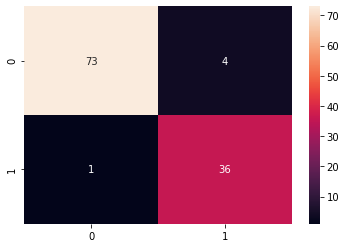

In [22]:

cm = confusion_matrix(test_labels, y_pred)
print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1])/test_labels.shape[0])*100))
sns.heatmap(cm,annot=True)
plt.savefig("img/heatmap.png")


In [24]:

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Entrenamiento y validación '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

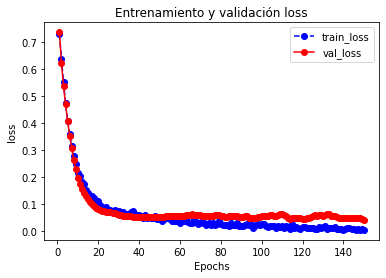

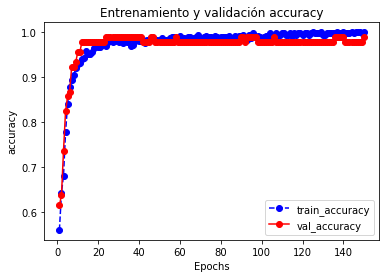

In [25]:

plot_metric(history, 'loss')
plot_metric(history, 'accuracy')